In [1]:
import numpy as np
from qiskit.quantum_info import random_statevector

# 2 Qubits

In [2]:
n_qubits = 2

### Generate "unkown" state you want to learn

In [3]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4]:
measurement_strings = ["0", "1", "+", "-", "i", "-i"]

zero = np.array([1, 0]).reshape(-1, 1)
one = np.array([0, 1]).reshape(-1, 1)
plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)

basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [5]:
# 2 qubits
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
two_qubit_measurement_operators = []
for qubit_1_op in measurement_operators:
    for qubit_2_op in measurement_operators:
        two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [6]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [7]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [8]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [9]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [10]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [11]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [12]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [13]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [14]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

In [15]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

np.float64(0.9999560782000441)

In [16]:
print(unkown_dm)

[[ 0.23087722+9.18010136e-19j -0.06769435+4.78054129e-02j
   0.05568279-1.86274423e-01j -0.23129304+2.81797522e-01j]
 [-0.06769435-4.78054129e-02j  0.0297469 +5.49562286e-19j
  -0.05489643+4.30869133e-02j  0.12616523-3.47329206e-02j]
 [ 0.05568279+1.86274423e-01j -0.05489643-4.30869133e-02j
   0.1637179 -3.45549137e-18j -0.28314059-1.18646201e-01j]
 [-0.23129304-2.81797522e-01j  0.12616523+3.47329206e-02j
  -0.28314059+1.18646201e-01j  0.57565798-1.28517838e-17j]]


In [17]:
print(found_dm)

[[ 0.23088385+0.j         -0.06769072+0.0478032j   0.055674  -0.18626736j
  -0.23127826+0.28177167j]
 [-0.06769072-0.0478032j   0.02976165+0.j         -0.0549007 +0.04309512j
   0.12616672-0.03472062j]
 [ 0.055674  +0.18626736j -0.0549007 -0.04309512j  0.1637239 +0.j
  -0.28312534-0.11865691j]
 [-0.23127826-0.28177167j  0.12616672+0.03472062j -0.28312534+0.11865691j
   0.5756306 +0.j        ]]


### Plot Density Matrices

In [18]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib notebook

In [19]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

<IPython.core.display.Javascript object>


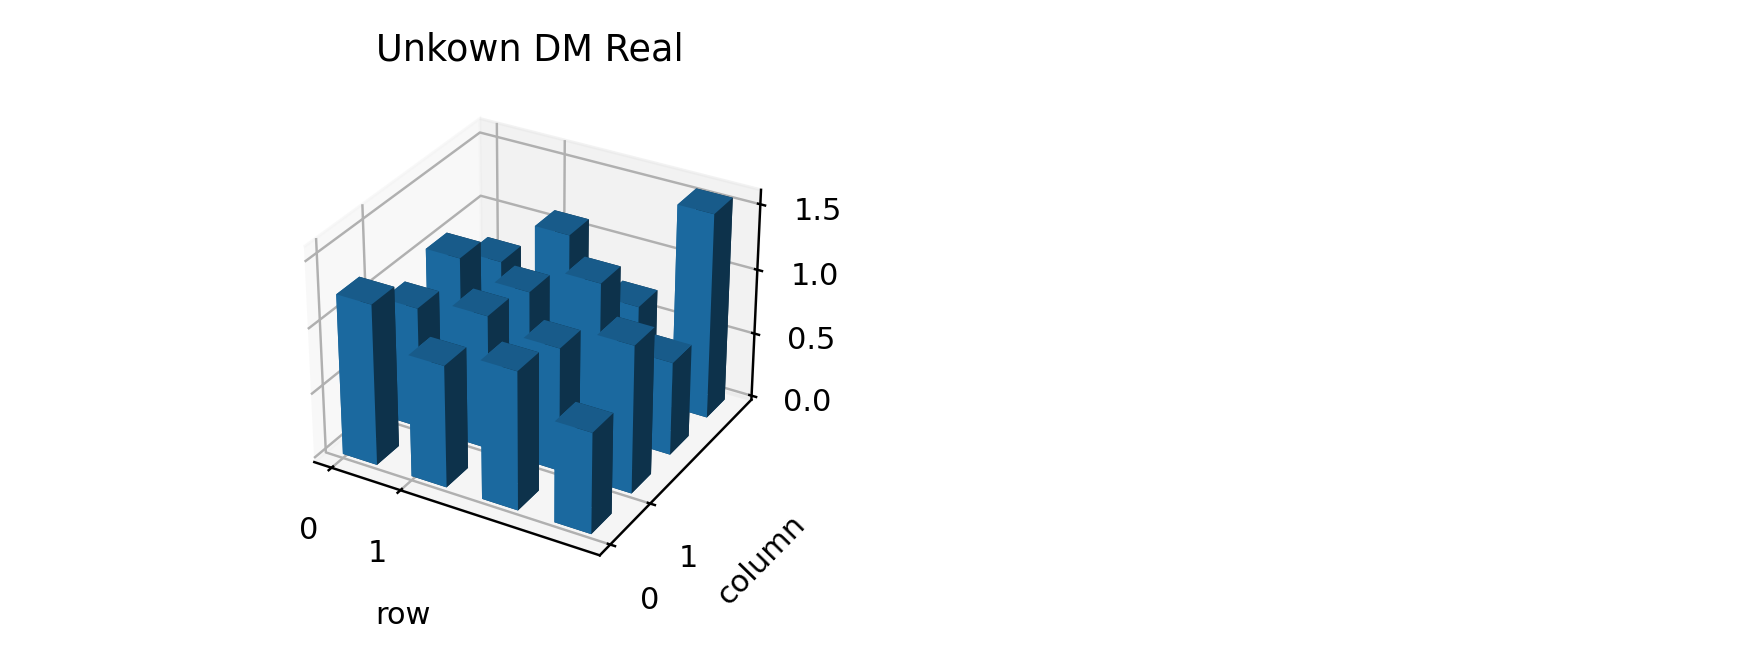

[[1.23087722 0.93230565 1.05568279 0.76870696]
 [0.93230565 1.0297469  0.94510357 1.12616523]
 [1.05568279 0.94510357 1.1637179  0.71685941]
 [0.76870696 1.12616523 0.71685941 1.57565798]]


In [20]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

<IPython.core.display.Javascript object>


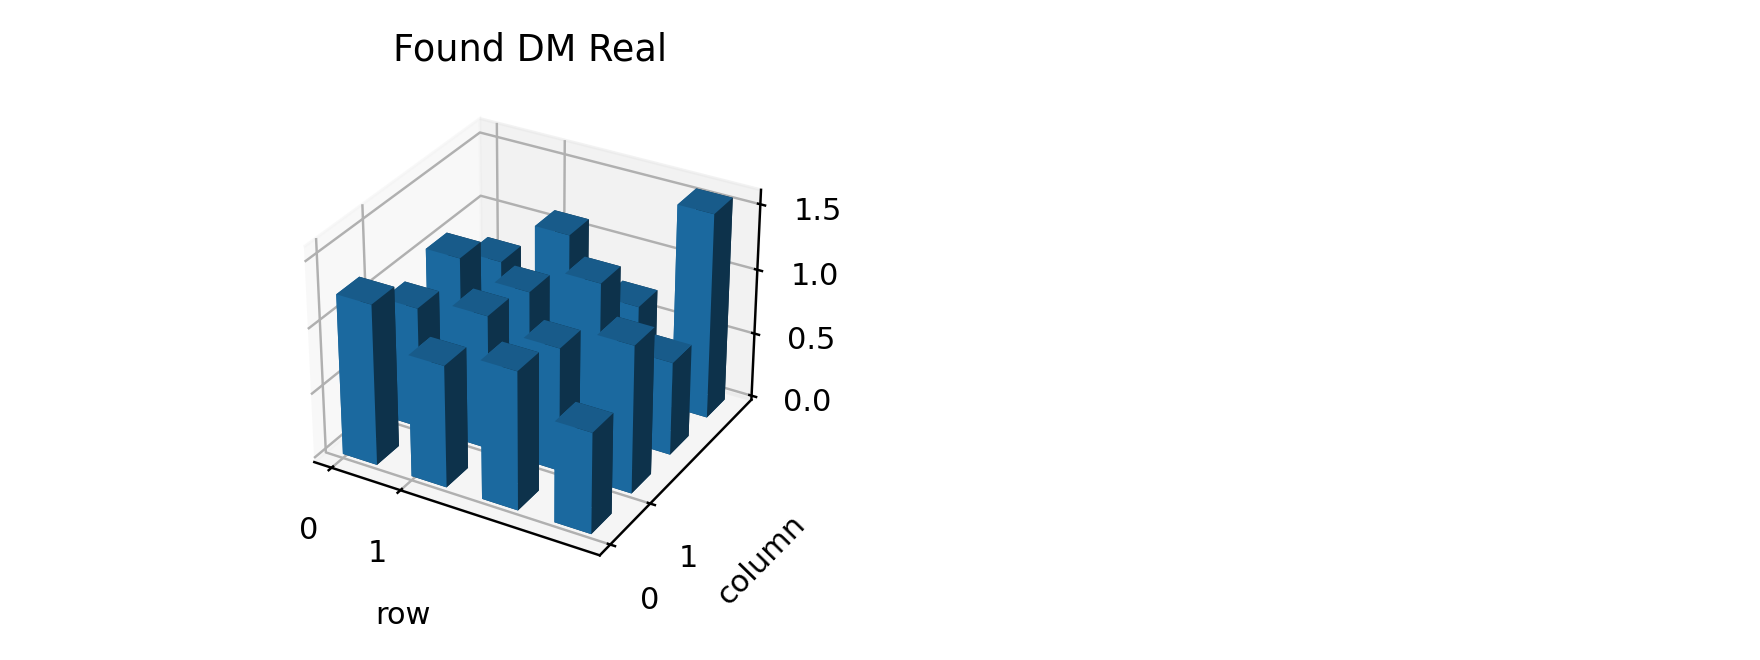

[[1.23088385 0.93230928 1.055674   0.76872174]
 [0.93230928 1.02976165 0.9450993  1.12616672]
 [1.055674   0.9450993  1.1637239  0.71687466]
 [0.76872174 1.12616672 0.71687466 1.5756306 ]]


In [21]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

<IPython.core.display.Javascript object>


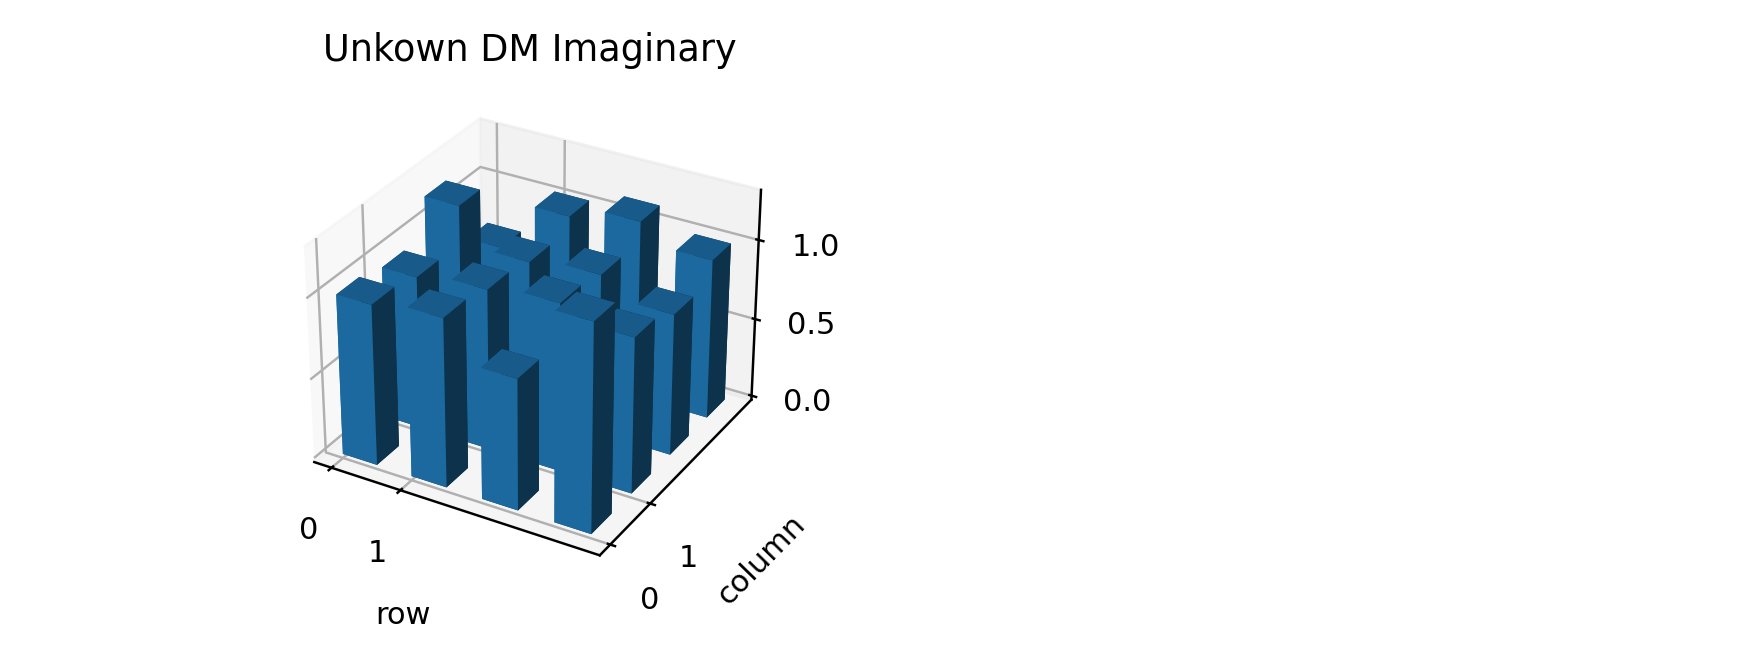

[[1.         1.04780541 0.81372558 1.28179752]
 [0.95219459 1.         1.04308691 0.96526708]
 [1.18627442 0.95691309 1.         0.8813538 ]
 [0.71820248 1.03473292 1.1186462  1.        ]]


In [22]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

<IPython.core.display.Javascript object>


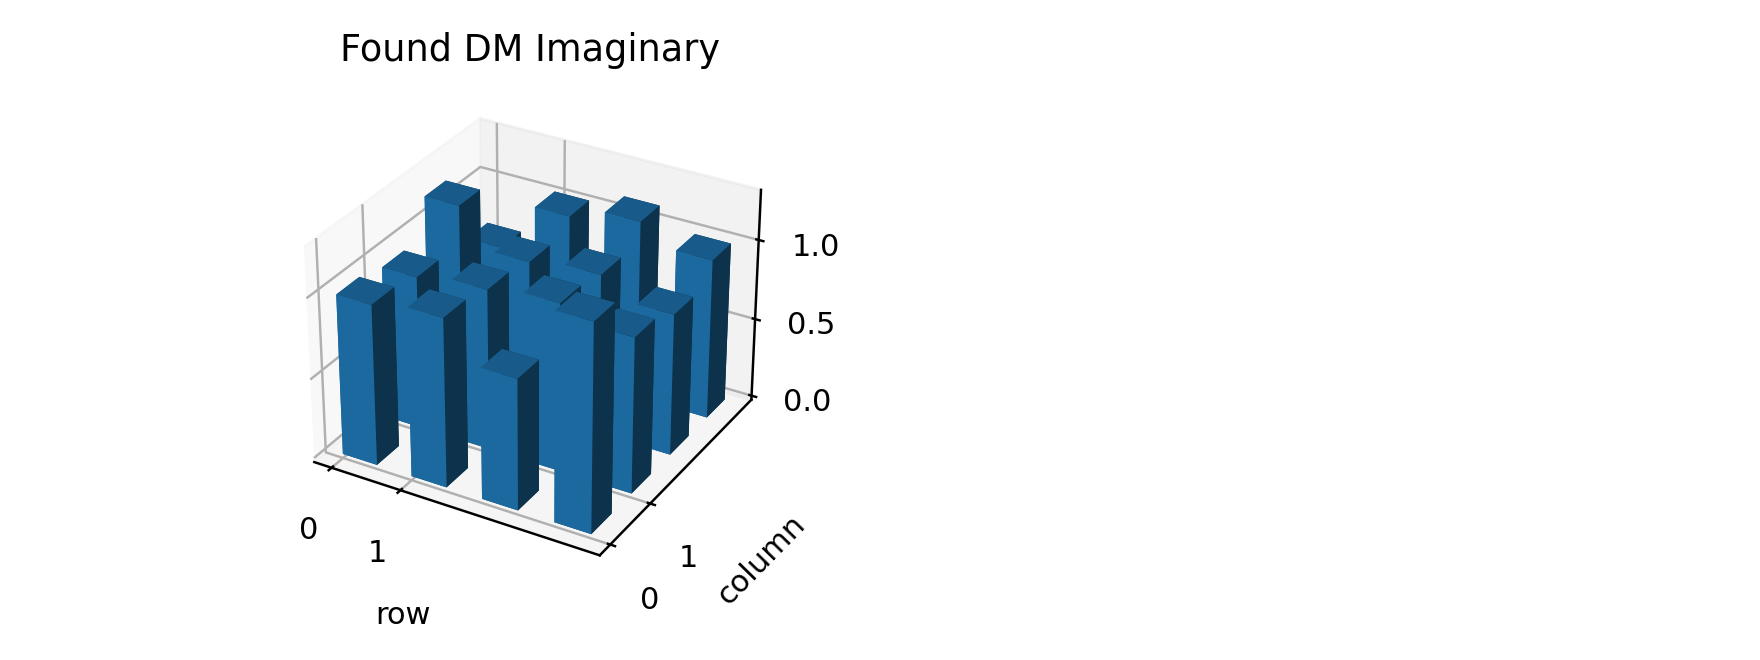

[[1.         1.0478032  0.81373264 1.28177167]
 [0.9521968  1.         1.04309512 0.96527938]
 [1.18626736 0.95690488 1.         0.88134309]
 [0.71822833 1.03472062 1.11865691 1.        ]]


In [23]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)